<a href="https://colab.research.google.com/github/christoph-fraller/dopp_2020w_group03_ex3/blob/main/dopp_2020w_group03_ex3_with_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate SSH-Keys for Accessing Git Repository

In [1]:
# import and mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# generate ssh keys (insert your username@github.com + hit enter when prompted for any answer)
! ssh-keygen -t rsa -b 4096 -C 'michaelstitz@github.com'

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa.
Your public key has been saved in /root/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256://o6Tt7w9QoDHX0sEGZIX/GpE7DFeE5RCEPO7ZBOFGU michaelstitz@github.com
The key's randomart image is:
+---[RSA 4096]----+
|         .oO@E*o |
|          ==OO o.|
|           B*oo.+|
|          o.oooo |
|        S ...+   |
|         . .  .  |
|          + o .  |
|         o.= + . |
|         .=== ...|
+----[SHA256]-----+


In [ ]:
# check whether or not the ssh keys have been created ('id_rsa' and 'id_rsa.pub' should be displayed)
! ls /root/.ssh/

id_rsa	id_rsa.pub


In [ ]:
# create directory for saving the ssh keys
! mkdir -p /content/drive/MyDrive/Ssh

In [ ]:
# copy ssh keys from /root/.ssh/* to /content/drive/MyDrive/Ssh/*
! cp /root/.ssh/id_rsa /content/drive/MyDrive/Ssh/
! cp /root/.ssh/id_rsa.pub /content/drive/MyDrive/Ssh/

In [ ]:
# display public ssh key for copy/paste
! cat /content/drive/MyDrive/Ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQCvxImXcy+Ne9tj2JEGPtdURItEVF034U9MbtcYCBYvHscyLpUwyKamqlP1f+tpUpChLiDcA4/rTYbOtd3cFJhuisEA67vrvDzUju24C9MwrWEtTVwIqKz77th9r1oOgRvewNdBxj3ODlvYC4zv8DT/krL1UcmxC5jm42rGvfb157tWLabAEQOG4VEM91ZhumJ6zg3dFs34ZWc3GzE84M2bBWIUW7oJqH5zHq6NO+Jx8ry+BCJoXXRSHMvNRQbxFYSJkaLnKhkKzLxusL9OvW+gGmEinlZOD0wi4J6k7oDUcOAgGXx6xrXLpsGLZbzP78fH1cdUknVZOzKTHDh1qiRnUFzk2SlVR8Sbn9a2GGBezUc1U1Gsfo5AzTM7mar/mOaxvCh40kgBNxbJiifLJ3kKjy3/zcsWfSqnsef2tNrv+xETxswj6t0YW7EIvxaARvH36FEI405q5YBqqSvTqXyMRb7iIsqqUgmND9ZrFdItvhZTuNcdh5m6d4hHoehg13/slkmz0h+9cRpGvHJq96XIzypW41TkgazNIK65CoZAEGAPysEX2p0O3EwD8wRl4k04Qu6Fl+c2gvZaKRsQ38OUnYgox3Mdu5G/0WsKdOSSinym5C462D+qXI1runuO95uK8iy33wKSjJGdYhHqjeLzEWaju92Ltx7voMQSIEFhaw== yummakan@github.com

In [ ]:
# add github to known hosts and adapt file access permissions
! ssh-keyscan github.com >> /root/.ssh/known_hosts
! chmod 644 /root/.ssh/known_hosts
! chmod 600 /root/.ssh/id_rsa
! ssh -T git@github.com

# Git Setup

In [ ]:
# git config settings (replace with your credentials)
! git config --global user.email "michaelstitz@gmail.com"
! git config --global user.name "michaelstitz"

In [ ]:
# create directory for git repositories
! mkdir -p /content/drive/MyDrive/Git

In [ ]:
# git-clone has to be performed only once when setting up the git repo at your google drive
! git clone git@github.com:christoph-fraller/dopp_2020w_group03_ex3.git /content/drive/MyDrive/Git/dopp_2020w_group03_ex3

Cloning into '/content/drive/MyDrive/Git/dopp_2020w_group03_ex3'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


## Important Shell and Git Commands

**NOTICE:** Always ensure that you are in the right directory when performing git commands (e.g. /content/drive/MyDrive/Git/dopp_2020w_group03_ex3). In case of any issues that might occur when switching directories it is highly recommended to restart the runtime engine (CTRL + M + .).

In [ ]:
# check current working directory
! pwd

/content


In [ ]:
# switch to specified working directory
%cd /content/drive/MyDrive/Git/dopp_2020w_group03_ex3

[Errno 2] No such file or directory: '/content/drive/MyDrive/Git/dopp_2020w_group03_ex3'
/content


In [ ]:
# list content of current working directory
! ls

sample_data


In [ ]:
# check git status
! git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# always perform a git pull before you start working or commit/push some changes
! git pull

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# add a new data file to git repo directly from colab
# at first upload the file into the folder of your google drive
# ! git add data/world_bank_income_level_thresholds.csv
# ! git commit -m 'New file added.'
# ! git push

[main 5f5e270] New file added.
Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 1.20 KiB | 307.00 KiB/s, done.
Total 6 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), done.
To github.com:christoph-fraller/dopp_2020w_group03_ex3.git
   3e96cae..5f5e270  main -> main


# Perform these steps everytime when a new session has been started

In [ ]:
# import and mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# create directory
! mkdir -p /root/.ssh

In [3]:
# copy ssh keys from /content/drive/MyDrive/Ssh/* to /root/.ssh/*
! cp /content/drive/MyDrive/Ssh/id_rsa /root/.ssh/
! cp /content/drive/MyDrive/Ssh/id_rsa.pub /root/.ssh/ 

In [4]:
# add github to known hosts and adapt file access permissions
! ssh-keyscan github.com >> /root/.ssh/known_hosts
! chmod 644 /root/.ssh/known_hosts
! chmod 600 /root/.ssh/id_rsa
! ssh -T git@github.com

# github.com:22 SSH-2.0-babeld-e6ec869a
# github.com:22 SSH-2.0-babeld-e6ec869a
# github.com:22 SSH-2.0-babeld-e6ec869a
Hi christoph-fraller/dopp_2020w_group03_ex3! You've successfully authenticated, but GitHub does not provide shell access.


In [5]:
# switch to specified working directory
%cd /content/drive/MyDrive/Git/dopp_2020w_group03_ex3

/content/drive/MyDrive/Git/dopp_2020w_group03_ex3


In [6]:
# always perform a git pull before you start working or commit/push some changes
! git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From github.com:christoph-fraller/dopp_2020w_group03_ex3
   bca2f9c..c2cf954  main       -> origin/main
Updating bca2f9c..c2cf954
Fast-forward
 dopp_2020w_group03_ex3_with_git.ipynb | 3656 ++++++++++++++++++---------------
 1 file changed, 2011 insertions(+), 1645 deletions(-)


## Geopanda installation

In [7]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 

In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import geopandas

# Data Preprocessing

###Load and merge income data


In [39]:
# load income data from csv
income_data = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/undata_gni_per_capita.csv', sep = ';')

# extend income data by adding an entry for each combination of (calendar_year, country_code) due to there are no missing entries in the data
country_data_list = income_data[['country_code', 'country_name']].drop_duplicates().values.tolist()
output_list = []
for lst in country_data_list:
    country_code = lst[0]
    country_name = lst[1]
    for calendar_year in range(1970, 2019):
      output_list.append([calendar_year, country_code, country_name])
df = pd.DataFrame(output_list, columns = ['calendar_year', 'country_code', 'country_name'])
income_data_complete = df.merge(income_data[['calendar_year', 'country_code', 'gni_per_capita_us_dollar']], how = 'left', on = ['calendar_year', 'country_code'])

# load population data from csv
population_data = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/undata_population_total.csv', sep = ';', 
                              usecols = ['country_code', 'calendar_year', 'population_total'])
population_data.drop_duplicates(inplace = True)
population_data['population_total'] = population_data['population_total'] * 1000 # total population is specified in 1000

# load country codes from csv
country_codes = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/iso3166_unsd_country_codes.csv', sep = ';', 
                            usecols = ['m49_code', 'iso_alpha2_code', 'iso_alpha3_code', 'small_island_developing_states'])

# merge income with population data and country codes
merged_income_data = income_data_complete.merge(population_data, how = 'left', on = ['calendar_year', 'country_code'])
merged_income_data = merged_income_data.merge(country_codes, how = 'left', left_on = 'country_code', right_on = 'm49_code')

# drop small island countries
merged_income_data.drop(merged_income_data[merged_income_data['small_island_developing_states'] == 'x'].index, inplace = True)
merged_income_data.drop(merged_income_data[merged_income_data['country_name'] == 'Former Netherlands Antilles'].index, inplace = True)
merged_income_data.drop(merged_income_data[merged_income_data['country_name'] == 'United Republic of Tanzania: Mainland'].index, inplace = True)
merged_income_data.drop(merged_income_data[merged_income_data['country_name'] == 'United Republic of Tanzania: Zanzibar'].index, inplace = True)
merged_income_data.reset_index(drop = True, inplace = True)

# restructure dataframe
merged_income_data.drop(['country_code'], axis = 1, inplace = True)
merged_income_data.rename(columns = {'country_code': 'm49_code'}, inplace = True)
merged_income_data = merged_income_data[['calendar_year', 'iso_alpha3_code', 'iso_alpha2_code', 'm49_code', 'country_name', 'population_total', 'gni_per_capita_us_dollar']] 

merged_income_data.tail()

,calendar_year,iso_alpha3_code,iso_alpha2_code,m49_code,country_name,population_total,gni_per_capita_us_dollar
8325,2014,ZWE,ZW,716.0,Zimbabwe,13586707.0,1298.569589
8326,2015,ZWE,ZW,716.0,Zimbabwe,13814629.0,1301.574535
8327,2016,ZWE,ZW,716.0,Zimbabwe,14030331.0,1338.026334
8328,2017,ZWE,ZW,716.0,Zimbabwe,14236595.0,1410.421297
8329,2018,ZWE,ZW,716.0,Zimbabwe,14438802.0,1572.613043


## Exploring missing values in income data

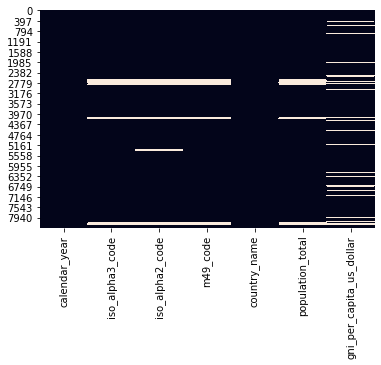

In [40]:
# get an overview of missing values in income data: it seems there is pattern between the missing values of the columns 
# iso_alpha3_code, iso_alpha2_code, m49_code and population_total
sb.heatmap(merged_income_data.isna(), cbar = False);

In [41]:
# obtain the countries with missing country codes
iso_alpha3_code_set = set(merged_income_data.loc[merged_income_data['iso_alpha3_code'].isna()].country_name.unique().tolist())
iso_alpha2_code_set = set(merged_income_data.loc[merged_income_data['iso_alpha2_code'].isna()].country_name.unique().tolist())
m49_code_set = set(merged_income_data.loc[merged_income_data['m49_code'].isna()].country_name.unique().tolist())
union_set = iso_alpha3_code_set | iso_alpha2_code_set | m49_code_set

# 'Nambia': iso_alpha2_code of the country corresponds to 'NA', which is interpreted as NA per default - we have to fix this when inserting the other missing country codes

# 'Kosovo': has declared its independence from Serbia in 2008 but until today this declaration is quite controversial. Due to reasons of simplicity and without being politically, 
# we have decided to exclude the Kosovo from our analysis.
merged_income_data.drop(merged_income_data[merged_income_data['country_name'] == 'Kosovo'].index, inplace = True)

# 'Yemen': TODO
merged_income_data.set_index(['calendar_year'], inplace = True)
yemen_missing_gni_values = (merged_income_data[merged_income_data['country_name'] == 'Yemen: Former Democratic Yemen'].gni_per_capita_us_dollar + merged_income_data[merged_income_data['country_name'] == 'Yemen: Former Yemen Arab Republic'].gni_per_capita_us_dollar) / 2
yemen_missing_gni_values.dropna(inplace = True)
yemen_df = pd.DataFrame(merged_income_data[merged_income_data['country_name'] == 'Yemen'].gni_per_capita_us_dollar.fillna(yemen_missing_gni_values))
yemen_df['country_name'] = 'Yemen'
yemen_df.reset_index(inplace = True)
yemen_df.set_index(['calendar_year', 'country_name'], inplace = True)
merged_income_data.reset_index(inplace = True)
merged_income_data.set_index(['calendar_year', 'country_name'], inplace = True)
merged_income_data.fillna(yemen_df, inplace = True)
merged_income_data.reset_index(inplace = True)
merged_income_data.drop(merged_income_data[merged_income_data['country_name'] == 'Yemen: Former Democratic Yemen'].index, inplace = True)
merged_income_data.drop(merged_income_data[merged_income_data['country_name'] == 'Yemen: Former Yemen Arab Republic'].index, inplace = True)
merged_income_data.reset_index(inplace = True, drop = True)

merged_income_data[merged_income_data['country_name'] == 'Yemen']
# rest of the missing country codes can be traced back to former countries that no longer exist:
# we will insert them from historical data of iso3166

,calendar_year,country_name,iso_alpha3_code,iso_alpha2_code,m49_code,population_total,gni_per_capita_us_dollar
8036,1970,Yemen,YEM,YE,887.0,6193384.0,90.823545
8037,1971,Yemen,YEM,YE,887.0,6290365.0,92.989332
8038,1972,Yemen,YEM,YE,887.0,6390574.0,117.934839
8039,1973,Yemen,YEM,YE,887.0,6500816.0,100.112566
8040,1974,Yemen,YEM,YE,887.0,6629999.0,114.803133
8041,1975,Yemen,YEM,YE,887.0,6784695.0,128.793604
8042,1976,Yemen,YEM,YE,887.0,6967941.0,147.621662
8043,1977,Yemen,YEM,YE,887.0,7178675.0,172.343178
8044,1978,Yemen,YEM,YE,887.0,7414158.0,189.422844
8045,1979,Yemen,YEM,YE,887.0,7669694.0,203.039570


In [42]:
merged_income_data.loc[merged_income_data['gni_per_capita_us_dollar'].isna()].country_name.unique().tolist()

['Armenia',
 'Azerbaijan',
 'Belarus',
 'Bosnia and Herzegovina',
 'Croatia',
 'Czech Republic',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Former Czechoslovakia',
 'Former Ethiopia',
 'Former Sudan',
 'Former USSR',
 'Former Yugoslavia',
 'Georgia',
 'Kazakhstan',
 'Kyrgyzstan',
 'Latvia',
 'Lithuania',
 'Montenegro',
 'Republic of Moldova',
 'Republic of North Macedonia',
 'Russian Federation',
 'Serbia',
 'Slovakia',
 'Slovenia',
 'South Sudan',
 'Sudan',
 'Tajikistan',
 'Turkmenistan',
 'Ukraine',
 'Uzbekistan']

## Insert missing country codes

In [46]:
def insert_missing_country_codes(input_data):

    df = pd.DataFrame(input_data)

    country_codes_list = ['iso_alpha3_code', 'iso_alpha2_code', 'm49_code']   

    # load formerly used country codes from csv
    former_country_codes = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/iso3166_formerly_used_country_codes.csv', sep = ';', na_filter = False)

    # insert missing values
    for row_index in range(0, len(df)):
      
      for country_code in country_codes_list:
        
        # check if country code value is missing
        if(pd.isnull(df.loc[row_index, country_code])):
          
          # insert missing missing country code
          df.loc[row_index, country_code] = former_country_codes.loc[former_country_codes[former_country_codes['country_name'] == df.loc[row_index, 'country_name']].index[0], country_code]

    return df
    
income_data_country_codes_inserted = insert_missing_country_codes(merged_income_data)

## Compute missing population data

In [ ]:
def compute_missing_population_total(input_data):

    df = pd.DataFrame(input_data)

    former_country_lists = [['Former Czechoslovakia', 'Czech Republic', 'Slovakia'],
                             ['Former Ethiopia', 'Ethiopia', 'Eritrea'],
                             ['Former Sudan', 'Sudan', 'South Sudan'],
                             ['Former USSR', 'Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyzstan', 'Latvia', 'Lithuania', 
                              'Republic of Moldova', 'Russian Federation', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan'],
                             ['Former Yugoslavia', 'Bosnia and Herzegovina', 'Croatia', 'Montenegro', 'Republic of North Macedonia', 'Serbia', 'Slovenia']]

    for country_list in former_country_lists:

      # get first list elem of list
      former_country_name = country_list.pop(0)

      # get list of calendar_years
      calendar_year_list = df.loc[df['country_name'] == former_country_name].calendar_year.tolist()

      for calendar_year in calendar_year_list:
        
        # get current index of former_country at particular calender_year
        curr_former_country_index = df.loc[(df['calendar_year'] == calendar_year) & (df['country_name'] == former_country_name)].population_total.index.max()
        
        # initialize new_population_total 
        new_population_total = 0

        for country_name in country_list:
          
          if pd.isnull(df.loc[(df['calendar_year'] == calendar_year) & (df['country_name'] == country_name)].gni_per_capita_us_dollar).bool():
            # get current index of country at particular calender_year  
            curr_country_index = df.loc[(df['calendar_year'] == calendar_year) & (df['country_name'] == country_name)].population_total.index.max()

            # increment new_population_total by population_total of curr_country_index at particular calender_year 
            new_population_total += df.loc[curr_country_index, 'population_total']

        # update population_total of former_country with new_population_total at particular calender_year 
        df.loc[curr_former_country_index, 'population_total'] = new_population_total if new_population_total > 0 else np.nan

    return df
    
income_data_preprocessed = compute_missing_population_total(income_data_country_codes_inserted)

NameError: ignored

In [ ]:
income_data_preprocessed.loc[income_data_preprocessed['country_name'] == 'Yemen']

In [ ]:
# get an overview of missing values in income data
sb.heatmap(income_data_preprocessed.isna(), cbar = False);

# it seems there is pattern between the missing values of the columns iso_alpha3_code, iso_alpha2_code, m49_code and population_total
income_data_preprocessed.loc[income_data_preprocessed['gni_per_capita_us_dollar'].isna()].country_name.unique().tolist()

## Load thresholds and sdr deflators


In [ ]:
# load income-level thresholds
income_threshold_data = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/world_bank_income_level_thresholds.csv', sep = ',')
income_threshold_data.drop(['banks_fiscal_year'], axis = 1, inplace = True)

# load sdr deflator values
sdr_deflator_data = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/world_bank_sdr_deflator.csv', sep = ',')
sdr_deflator_data.drop(['sdr_deflator_us_dollar'], axis = 1, inplace = True)

# create index on calendar_year
income_threshold_data.set_index(['calendar_year'], inplace = True)
sdr_deflator_data.set_index(['calendar_year'], inplace = True)

# merge income_threshold_data and sdr_deflator_data using index 'calendar_year'
threshold_data = income_threshold_data.merge(sdr_deflator_data, how = 'inner', left_index = True, right_index = True)

# visualize missing threshold values using a heatmap
sb.heatmap(threshold_data[['low_income_level_threshold', 'middle_income_level_threshold', 'high_income_level_threshold']].isna(), cbar = False);

## Calculate missing thresholds using sdr deflators


In [ ]:
def calculate_missing_thresholds(input_data):
    
    df = pd.DataFrame(input_data)
    
    thresholds_list = ['low_income_level_threshold', 'middle_income_level_threshold', 'high_income_level_threshold']   
    
    # calculate missing values
    for row_index in range(0, len(df)):
      
      # retrieve current index
      curr_index = df.index.max() - row_index
      for threshold in thresholds_list:
        
        # check if threshold value is missing
        if(np.isnan(df.loc[curr_index, threshold])):
          
          # calculate missing threshold value based on existing threshold and sdr_inflation_rate_annual_change
          df.loc[curr_index, threshold] = df.loc[curr_index + 1, threshold] / (100 + df.loc[curr_index + 1, 'sdr_inflation_rate_annual_change']) * 100
    
    # round thresholds to nearest multiple of base
    base = 5
    for threshold in thresholds_list:
      df[threshold] = round(df[threshold] / base) * base

    return df[thresholds_list]

threshold_data_complete = calculate_missing_thresholds(threshold_data)

# check whether or not all missing values have been replaced
sb.heatmap(threshold_data_complete.isna(), cbar = False);

## Assign income-level labels based on gni and income-level thresholds

In [ ]:
# merge income_data_preprocessed and threshold_data_complete using calendar_year
income_classification_data = income_data_preprocessed.merge(threshold_data_complete, how = 'left', on = 'calendar_year')

# assign income-level labels based on gni and thresholds
income_classification_data.loc[(income_classification_data['gni_per_capita_us_dollar'] <= income_classification_data['low_income_level_threshold']), 'income_level_label'] = 'low_income'
income_classification_data.loc[((income_classification_data['gni_per_capita_us_dollar'] > income_classification_data['low_income_level_threshold']) & 
                        (income_classification_data['gni_per_capita_us_dollar'] <= income_classification_data['middle_income_level_threshold'])), 'income_level_label'] = 'lower_middle_income'
income_classification_data.loc[((income_classification_data['gni_per_capita_us_dollar'] > income_classification_data['middle_income_level_threshold']) & 
                        (income_classification_data['gni_per_capita_us_dollar'] <= income_classification_data['high_income_level_threshold'])), 'income_level_label'] = 'upper_middle_income'
income_classification_data.loc[(income_classification_data['gni_per_capita_us_dollar'] > income_classification_data['high_income_level_threshold']), 'income_level_label'] = 'high_income'

# create index on calendar_year and iso_alpha3_code
#income_classification_data.reset_index(inplace = True)
#income_classification_data.set_index(['calendar_year', 'iso_alpha3_code'], inplace = True)

income_classification_data.tail()

In [ ]:
# counts the number of missing values (years) in gni data (population_total only placeholder in that line)
income_classification_data.loc[income_classification_data['gni_per_capita_us_dollar'].isna()].groupby('country_name').count()

# Question 1

In [ ]:
#interesing countries [Russian Federation, Ukraine, South Sudan, Venezuela, RB, Korea, Dem. People’s Rep., ......]
income_classification_data.loc[income_classification_data['country_name'] == 'Former Yugoslavia']

### Finding countries with few entries

In [ ]:
country_with_missing_entries = pd.DataFrame()

country_with_missing_entries['gni_missing_years'] = income_classification_data.loc[income_classification_data['gni_per_capita_us_dollar'].isna()].groupby('country_name')['population_total'].count() #counts the number of missing year in gni data (population_totlal only placeholder in that line)
country_with_missing_entries['population_maximum_when_missing'] = income_classification_data.loc[income_classification_data['gni_per_capita_us_dollar'].isna()].groupby('country_name')['population_total'].max()

country_with_missing_entries[country_with_missing_entries['population_maximum_when_missing'] > 1.5e7]

## Calculating the population living in the different income levels

In [ ]:
#create sum of population of each income category for each year

income_classification_data.set_index('calendar_year', inplace = True)

population_income = pd.DataFrame()
population_income['low_income_population'] = income_classification_data['population_total'].loc[income_classification_data['income_level_label'] == 'low_income'].groupby('calendar_year').sum()
population_income['lower_middle_income_population'] = income_classification_data['population_total'].loc[income_classification_data['income_level_label'] == 'lower_middle_income'].groupby('calendar_year').sum()
population_income['upper_middle_income_population'] = income_classification_data['population_total'].loc[income_classification_data['income_level_label'] == 'upper_middle_income'].groupby('calendar_year').sum()
population_income['high_income_population'] = income_classification_data['population_total'].loc[income_classification_data['income_level_label'] == 'high_income'].groupby('calendar_year').sum()
population_income['unknown_income_population'] = income_classification_data['population_total'].loc[income_classification_data['income_level_label'].isna()].groupby('calendar_year').sum()
population_income['total_population'] = income_classification_data['population_total'].groupby('calendar_year').sum()

population_income

## Visualisation

In [ ]:
#plot income classification count over time
plt.plot(population_income['high_income_population'], label = 'high_income' )
plt.plot(population_income['upper_middle_income_population'], label = 'upper_middle_income')
plt.plot(population_income['lower_middle_income_population'], label = 'lower_middle_income')
plt.plot(population_income['low_income_population'], label = 'low_income')
plt.plot(population_income['unknown_income_population'], label = 'unknown_income')
plt.xlabel('Calendar Year')
plt.ylabel('Number of People')
plt.legend()
plt.show()

#plot known / unknown classification count over time
plt.plot((population_income['total_population']-population_income['unknown_income_population']), label = 'known_income' )
plt.plot(population_income['unknown_income_population'], label = 'unknown_income')
plt.xlabel('Calendar Year')
plt.ylabel('Number of People')
plt.legend()
plt.show()

#plot income of the 5 lagrgest countries in 2018
countries_most_populous = income_classification_data.loc[2018].nlargest(5,'population_total')['country_name'].values
years = range(1970,2020)
high_income_treshold = threshold_data_complete[threshold_data_complete.index.isin(years)]['high_income_level_threshold'].values
middle_income_treshold = threshold_data_complete[threshold_data_complete.index.isin(years)]['middle_income_level_threshold'].values
low_income_treshold = threshold_data_complete[threshold_data_complete.index.isin(years)]['low_income_level_threshold'].values

fig, ax = plt.subplots()
for i in range(5):
  ax.plot(income_classification_data['gni_per_capita_us_dollar'].loc[income_classification_data['country_name']==countries_most_populous[i]],label = countries_most_populous[i])

plt.yscale('log')

ax.fill_between(years,high_income_treshold,1e5,alpha=0.3)
ax.fill_between(years,high_income_treshold, middle_income_treshold,alpha=0.3)
ax.fill_between(years,low_income_treshold, middle_income_treshold,alpha=0.3)
ax.fill_between(years,low_income_treshold,0, alpha=0.3)
ax.text(2004, 1.5e2, 'low income', fontsize=9, color = 'White')
ax.text(1980, 1.3e3, 'lower_middle_income', fontsize=9, color = 'White')
ax.text(1990, 5e3, 'upper_middle_income', fontsize=9, color = 'White')
ax.text(2000, 2e4, 'high_income', fontsize=9, color = 'White')

ax.set_xlabel('Calendar Year')
ax.set_ylabel('GNI per Capita in US Dollar')
plt.xlim([1970,2019])
plt.ylim([5e1,1e5])
plt.legend()
plt.show()


#show histogram of differtent income levels in 2018
income_classification_data['income_level_label'].loc[2018].hist( grid=False)
plt.show() 

# income_classification_data =  income_classification_data.loc[income_classification_data['population_total'] > 1000000.0]
# print(income_classification_data)
# print(income_classification_data[['population_total', 'income_level_label']].groupby(['calendar_year', 'income_level_label']).sum().groupby('calendar_year').sum())

#create df to show the sum of coutries for each income classification
income_classification_count = income_classification_data['income_level_label'].groupby('calendar_year').value_counts(dropna = False)

#plot income classification count over time [sum of countries]
plt.plot(income_classification_count[:,'high_income'], label = 'high_income' )
plt.plot(income_classification_count[:,'upper_middle_income'], label = 'upper_middle_income')
plt.plot(income_classification_count[:,'lower_middle_income'], label = 'lower_middle_income')
plt.plot(income_classification_count[:,'low_income'], label = 'low_income')
plt.xlabel('Calendar Year')
plt.ylabel('Number of Countries')
plt.legend()
plt.show()

#plot total count of classification entries each year [sum of countries]
income_classification_total_count = income_classification_count[:,'high_income']+income_classification_count[:,'upper_middle_income']+income_classification_count[:,'lower_middle_income']+income_classification_count[:,'low_income']
plt.plot(income_classification_total_count, label = 'total_classification_count', color = 'black')
plt.plot(income_classification_count[:,np.nan], label = 'no_classification')
plt.xlabel('Calendar Year')
plt.ylabel('Number of Countries')
plt.legend()
plt.show()


## World Map Visualtisation (Choropleth Map)

In [ ]:
#load geometry data for all countries 
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#correct wrong iso code
world['iso_a3'].loc[world['name'] == 'France'] = 'FRA'
world['iso_a3'].loc[world['name'] == 'Norway'] = 'NOR'
world['iso_a3'].loc[world['name'] == 'Kosovo'] = 'XKX'

#drop unnecessary columns
country_shapes = world[['geometry', 'iso_a3']]

#merge geometry with income data on country code, select year to look at
geo_income_data = country_shapes.merge(income_classification_data.loc[2018], left_on='iso_a3', right_on='iso_alpha3_code')

#plot map
legend_dict = {'bbox_to_anchor' : (1., 1), 'loc' :'upper left'}
missing_dict = {"color": "lightgrey","label": "unknown_income"}
colors = ['dodgerblue','maroon','lightcoral','skyblue']
geo_income_data.plot(column='income_level_label', legend = True, legend_kwds = legend_dict, figsize=(15, 10), missing_kwds = missing_dict, cmap = matplotlib.colors.ListedColormap(colors))



# Question 2

## Data Preprocessing

### Load Data

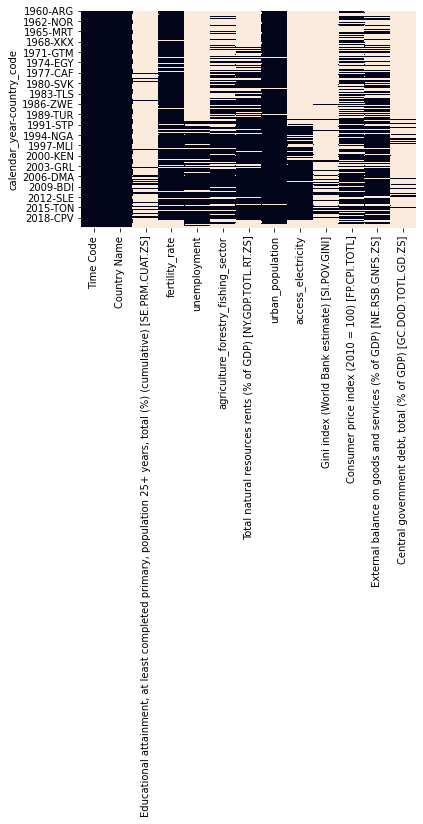

In [ ]:
# load indicator data from csv (World Bank Data)
indicator_data = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/data_indicators_1.csv', sep = ',')
indicator_data.replace('..',np.nan,inplace=True)

# drop GNI and Population Data (use this data from Question 1 (UN Data))
indicator_data.drop(labels= ['GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]','Population, total [SP.POP.TOTL]'], axis = 1, inplace = True)

#rename columns
rename_columns_dict = {'Time':'calendar_year','Country Code':'country_code','Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]':'fertility_rate','Urban population (% of total population) [SP.URB.TOTL.IN.ZS]':'urban_population','Access to electricity (% of population) [EG.ELC.ACCS.ZS]':'access_electricity', 'Agriculture, forestry, and fishing, value added (% of GDP) [NV.AGR.TOTL.ZS]':'agriculture_forestry_fishing_sector','Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]':'unemployment'}
indicator_data.rename(rename_columns_dict, axis='columns',inplace=True)

#set index 
indicator_data.set_index(['calendar_year','country_code'], inplace = True)

# only use Data from 1970 - 2018
#indicator_data = indicator_data.loc['1970':'2018']

# heatmap of missing values
sb.heatmap(indicator_data.isna(), cbar = False);

In [ ]:
# select only ceratain parameters (drop columns with very few entries)

indicator_data = indicator_data[['country_code','fertility_rate','urban_population','access_electricity', 'agriculture_forestry_fishing_sector','unemployment']]

indicator_data

,country_code,fertility_rate,urban_population,access_electricity,agriculture_forestry_fishing_sector,unemployment
Time,,,,,,
1970,ARG,3.079,78.88,NaN,9.6375609641048,NaN
1970,AUS,2.859,83.999,NaN,NaN,NaN
1970,BRA,4.972,55.909,NaN,10.3736196442959,NaN
1970,CHN,5.725,17.4,NaN,34.7984383910164,NaN
1970,FRA,2.55,71.055,NaN,6.62779041830419,NaN
...,...,...,...,...,...,...
2018,WSM,3.877,18.243,100,9.76989144032775,8.3120002746582
2018,SMR,NaN,97.226,100,NaN,NaN
2018,STP,4.321,72.803,71,11.3967458046852,13.1479997634888


### Merge with Data from Question 1

In [ ]:
income_classification_data

NameError: ignored